In [1]:
import sys
if 'ipykernel_launcher.py' not in sys.argv[0]:
    manual = False
    scenario = sys.argv[1]
else:
    manual = True
    scenario = 'intermodal'
    %matplotlib inline

In [2]:
sys.path.insert(0, r'../../../quetzal')
from quetzal.model import stepmodel
from quetzal.io import excel
from syspy.io.geojson_utils import gdf_to_geojson
import datetime
import winsound

import pandas as pd
import os
import json
import geopandas as gpd

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

SQLalchemy is not installed. No support for SQL output.


In [3]:
qpath = '../../'
mpath = qpath + 'model/'
ipath = qpath + 'inputs/'
opath = qpath + 'outputs/'

In [4]:
plt.rcParams.update({'font.size': 25})

# Define list of tests

In [5]:
if scenario == 'monomodal':
    fare_test = [
        ('base', 'fx', [25, 30, 35, 40, 45, 50, 55]),
        ('add', 'fx', [25, 30, 35, 40, 45, 50, 55])
    ]

if scenario == 'intermodal':
    fare_test = [
        ('base', 'fx', [25, 30, 35, 40, 45]),
        ('add', 'fx', [5, 10, 15, 20])
    ]

if scenario == 'multimodal':
    fare_test = [
        ('base', 'fx', [45, 50, 55, 60, 65, 70, 80, 90])
    ]

all_tests = {
    'fares': fare_test
}

In [6]:
parameter_frame = pd.read_excel(qpath + r'inputs/base_parametros.xlsx').set_index(['category','parameter'])

for c in parameter_frame.columns:
    parent = parameter_frame[c][('general', 'parent')]
    try:
        parent = parent.iloc[0]
    except AttributeError:# 'str' object has no attribute 'iloc'
        pass
    parameter_frame[c] = parameter_frame[c].fillna(parameter_frame[parent])

base_scenario_parameter_frame = pd.DataFrame(parameter_frame[scenario]).dropna()

In [7]:
import itertools
import shutil

def create_test_parameters_dataframe(
    test, test_name, reference_parameters_dataframe=base_scenario_parameter_frame
):
    # Create scenario parameters combination dataframe
    parameter_values = [v[2] for v in test]
    data = list(itertools.product(*parameter_values))

    if scenario == 'monomodal':
        
        def monomodal(i):
            if i[0]==i[1]:
                return True
            else:
                return False

        it = data.copy()

        for d in it:
            if not monomodal(d):
                data.remove(d)

    if scenario == 'intermodal':
        
        def intermodal(i):
            if i[0]==i[1]:
                return False
            else:
                return True

        it = data.copy()

        for d in it:
            if not intermodal(d):
                data.remove(d)

    df = pd.DataFrame(
        data=data,
        columns=pd.MultiIndex.from_arrays([[v[0] for v in test], [v[1] for v in test]]),
        index=[test_name +'_'+ str(i) for i in range(len(data))]
    )

    df.T.index.names = reference_parameters_dataframe.index.names  # Set index name
    
    # Merge with reference scenario
    scenario_parameter_frame = reference_parameters_dataframe.merge(
        df.T, left_index=True, right_index=True, how='outer'
    )

    scenario_parameter_frame.loc[('general','parent')] = scenario  # Set parent
    
    # Fill reference values
    for c in scenario_parameter_frame.columns:
        parent = scenario_parameter_frame[c][('general', 'parent')][0]
        scenario_parameter_frame[c] = scenario_parameter_frame[c].fillna(scenario_parameter_frame[parent])

    # Drop duplicates
    scenario_parameter_frame = scenario_parameter_frame.apply(
        pd.to_numeric, axis=1, errors='ignore'
    )
    temp = scenario_parameter_frame.T.drop_duplicates()

    return temp.T

def run_tests(
    all_tests_dict, reference_parameters_dataframe, clean=True, df=None,
):
    for test_name, test_values in all_tests_dict.items():
        print(test_name)
        # Create parameter frame
        if df is None:
            df = create_test_parameters_dataframe(test_values, test_name, reference_parameters_dataframe)

        df.reset_index().to_excel(qpath + r'inputs/parametros.xlsx', index=False)
        # run
        %run 0_python_launcher.ipynb

        if clean:
            # Delete intermediate model steps, except for base
            reference_scenario_name = reference_parameters_dataframe.loc[('general', 'parent')].values[0]
            import os
            models = list(
                (set(os.listdir(qpath + r'model/')).intersection(df.columns)).difference({reference_scenario_name})
            )
            for m in models:
                for step in ['links', 'pt_pathfinder', 'assigned']:
                    try:
                        f = qpath + r'model/{}/{}.zip'.format(m, step)
                        shutil.rmtree(f)
                    except FileNotFoundError:
                        pass


def read_result(scenario):
    try:
        temp = pd.read_excel(qpath + r'model/' + scenario + '/stacks.xlsx', sheet_name='earning').set_index('fare_id')['sum']
        try:
            r = temp['intrant'] - temp['concho'] - temp['minibus']
        except KeyError:
            r = None
    except FileNotFoundError:
        r = None
    return r
                    
                    
def read_tests(all_tests_dict, reference_parameters_dataframe):
    all_results = {}
    for test_name, test_values in all_tests_dict.items():
        df = create_test_parameters_dataframe(test_values, test_name, reference_parameters_dataframe)
        # Append results
        results = pd.concat(
            [
                df.apply(
                    lambda x: read_result(x.name)
                )
            ],
            keys=[('earnings')]
        )
        # results = results.apply(lambda x: round(x, 1))
        df = df.append(results.unstack())
        all_results.update({test_name: df})
    return all_results

In [8]:
df = create_test_parameters_dataframe(fare_test, 'fare')
print(len(df.columns))

20


# Run Tests

In [9]:
run_tests(all_tests, base_scenario_parameter_frame)

fares


  0%|          | 0/2 [00:00<?, ?it/s]

routes that belong to gtfs and not to parameters (will not be used):
{'Tele Oeste SDO', 'tramo SDO L2', 'sitp_tiradentes', 'intrant', 'quentin', 'Tele Oeste LA', 'Tramo Alcarrizos L2'}
{'sitp_tiradentes', 'independencia', 'AB_A20A_1', 'AB_A11_1', 'AB_A20B_2', 'AB_A20A_2', 'sitp_cdg_este', '27_febrero', 'AB_A-B_1', 'victoria', 'sanfelipe', 'sitp_josefa', 'sitp_lincoln', 'sitp_sabana_larga', 'sitp_nunez', 'sitp_churchill', 'sitp_defillo', 'sitp_venezuela', 'AB_A31_2', 'sitp_cdg_oeste', 'AB_A31_1', 'sitp_ortega', 'AB_A11_2', 'AB_A20B_1', 'sitp_prolongacion_27', 'AB_A69_1', 'AB_A69_2', 'AB_A-B_2'}


jsons: 100%|██████████| 2/2 [00:00<00:00,  8.06it/s]


0 4_pt_pathfinder.py intermodal
1 4_pt_pathfinder.py fares_0
2 4_pt_pathfinder.py fares_1
3 4_pt_pathfinder.py fares_2
4 4_pt_pathfinder.py fares_3
5 4_pt_pathfinder.py fares_4
6 4_pt_pathfinder.py fares_5
7 4_pt_pathfinder.py fares_6
8 4_pt_pathfinder.py fares_7
9 4_pt_pathfinder.py fares_8
10 4_pt_pathfinder.py fares_9
11 4_pt_pathfinder.py fares_11
12 4_pt_pathfinder.py fares_12
13 4_pt_pathfinder.py fares_13
14 4_pt_pathfinder.py fares_14
15 4_pt_pathfinder.py fares_15
16 4_pt_pathfinder.py fares_16
17 4_pt_pathfinder.py fares_17
18 4_pt_pathfinder.py fares_18
19 4_pt_pathfinder.py fares_19
414 seconds
0 5_modal_split.py intermodal
1 5_modal_split.py fares_0
2 5_modal_split.py fares_1
3 5_modal_split.py fares_2
4 5_modal_split.py fares_3
5 5_modal_split.py fares_4
6 5_modal_split.py fares_5
7 5_modal_split.py fares_6
8 5_modal_split.py fares_7
9 5_modal_split.py fares_8
10 5_modal_split.py fares_9
11 5_modal_split.py fares_11
12 5_modal_split.py fares_12
13 5_modal_split.py fares_1

100%|██████████| 20/20 [00:22<00:00,  1.13s/it]


FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: '../../models/'

# Read results

In [10]:
all_results = read_tests(all_tests, base_scenario_parameter_frame)

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
# from syspy.syspy_utils import data_visualization as dv
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 5)
plt.rcParams['font.size']=14

In [15]:
all_results['fares']

,intermodal,fares_0,fares_1,fares_2,fares_3,fares_4,fares_5,fares_6,fares_7,fares_8,...,fares_10,fares_11,fares_12,fares_13,fares_14,fares_15,fares_16,fares_17,fares_18,fares_19
"(add, fx)",15,5,10,15,20,5,10,15,20,5,...,15,20,5,10,15,20,5,10,15,20
"(base, fx)",35,25,25,25,25,30,30,30,30,35,...,35,35,40,40,40,40,45,45,45,45
"(fare_id, bus)","f0, f1, f2, f3, f4, f5",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(fare_id, concho)",concho,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(fare_id, express_bus)","f0, f1, f2, f3, f4, f5",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(transfers, integrated)",10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(transfers, minibus)",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(transfers, opret)",10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"(transfers, tram)",0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
def plot_2d(r, indicator_kwargs={}):
    fig, axes = plt.subplots(1, len(indicator_kwargs))
    axe_i = 0
    for indicator, kwargs in indicator_kwargs.items():
        temp = r[indicator].applymap(float)
        plot_kwargs = kwargs.get('plot_kwargs',{})
        ax=sns.heatmap(temp.applymap(float), ax=axes[axe_i], **plot_kwargs)
        for i in range(temp.shape[0]):
            for j in range(temp.shape[1]):
                text = axes[axe_i].text(
                    j+0.5, i+0.5, round(temp.iloc[i,j],2),
                    ha="center", va="center", color="k"
                )
        axes[axe_i].set_title(kwargs.get('plot_title', ''))
        
        axe_i += 1

    return fig, axes

def plot_1d(r, indicator_kwargs={}):
    fig, axes = plt.subplots(1, len(indicator_kwargs))
    axe_i = 0
    for indicator, kwargs in indicator_kwargs.items():
        temp = r.loc[indicator].sort_index()
        plot_kwargs = kwargs.get('plot_kwargs',{})
        temp.plot(ax=axes[axe_i], **plot_kwargs)
       
        axes[axe_i].set_title(kwargs.get('plot_title', ''))
        axe_i += 1

    
    return fig, axes

In [25]:
n_params = len(all_tests[test_name])

In [27]:
n_params

2

AttributeError: 'Series' object has no attribute 'applymap'

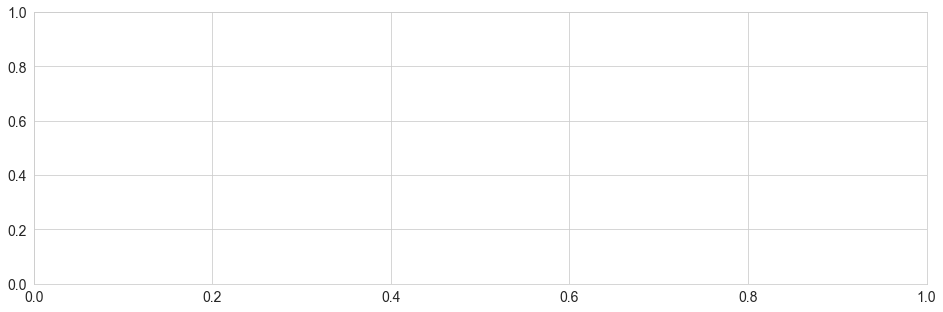

In [28]:
# Calibration tests
for test_name in all_tests.keys():
    params = [tuple([v[0], v[1]]) for v in all_tests[test_name]]
    n_params = len(all_tests[test_name])
    variable_name = ' '.join([x for x in test_name.split('_')[:-1] if x!='lrt'])

    result_names = [('earnings')]

    r = all_results[test_name].loc[
             params + result_names
    ].T.sort_values(params).set_index(params).dropna()

    if n_params==1:
        plot_1d(
            r,
            indicator_kwargs={
                ('earnings'): {
                    'plot_title': 'earnings vs. {}'.format(variable_name),
                    'plot_kwargs': {'ylim': [0, 100]}
                }
            }
        )

    if n_params==2:
        plot_2d(
            r,
            indicator_kwargs={
              'earnings': {
                    'plot_title': 'earnings vs. {}'.format(variable_name),
                    'plot_kwargs': {
                        'vmin': 0, 'vmax': 100,
                        'cmap': 'RdYlGn_r', 'square': True,
                    }
                }
            }
        )

    plt.tight_layout()    

In [34]:
sns.heatmap(r.unstack().values)

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

AttributeError: 'NoneType' object has no attribute 'reshape'

<Figure size 1152x360 with 2 Axes>

<AxesSubplot:xlabel='(base, fx)'>

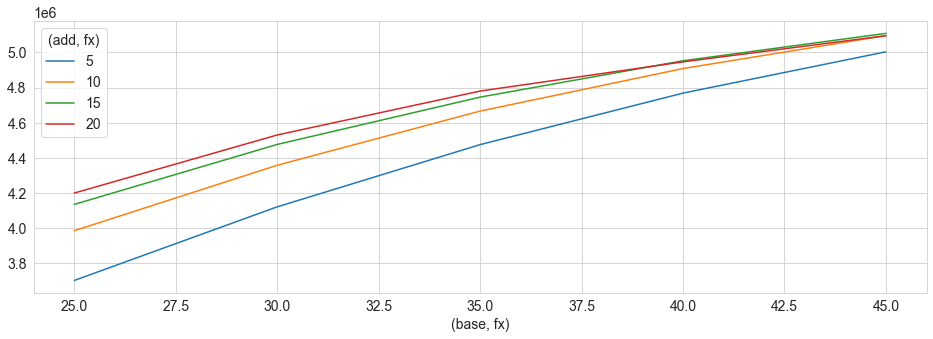

In [36]:
r['earnings'].unstack().plot()

In [ ]:
end_of_notebook

# results insight

In [ ]:
# all_results['all'].to_excel(opath + r'calibration_results_3000.xlsx')

In [ ]:
all_results['all'].loc[('results', 'score')].fillna(1000000).describe()

count     2500.000000
mean     10049.400303
std        209.799293
min       9844.724911
25%       9905.757454
50%       9970.445401
75%      10123.342190
max      11076.168264
Name: (results, score), dtype: float64

In [ ]:
filtered_results = [k for k,v in (all_results['all'].loc[('results', 'score')].fillna(0).map(int) < 9880).to_dict().items() if v == True]
filtered_results

['base',
 'all_28',
 'all_30',
 'all_31',
 'all_32',
 'all_33',
 'all_35',
 'all_36',
 'all_37',
 'all_38',
 'all_39',
 'all_40',
 'all_41',
 'all_42',
 'all_43',
 'all_44',
 'all_45',
 'all_46',
 'all_47',
 'all_48',
 'all_49',
 'all_55',
 'all_56',
 'all_57',
 'all_58',
 'all_59',
 'all_60',
 'all_61',
 'all_62',
 'all_63',
 'all_64',
 'all_65',
 'all_66',
 'all_67',
 'all_68',
 'all_69',
 'all_73',
 'all_74',
 'all_75',
 'all_80',
 'all_81',
 'all_82',
 'all_83',
 'all_84',
 'all_150',
 'all_151',
 'all_152',
 'all_153',
 'all_155',
 'all_156',
 'all_157',
 'all_158',
 'all_160',
 'all_161',
 'all_162',
 'all_163',
 'all_165',
 'all_166',
 'all_167',
 'all_169',
 'all_170',
 'all_171',
 'all_172',
 'all_173',
 'all_174',
 'all_175',
 'all_180',
 'all_181',
 'all_182',
 'all_270',
 'all_271',
 'all_275',
 'all_276',
 'all_277',
 'all_280',
 'all_281',
 'all_282',
 'all_283',
 'all_285',
 'all_286',
 'all_287',
 'all_288',
 'all_390',
 'all_391',
 'all_392',
 'all_395',
 'all_396',
 '

In [ ]:
df = all_results['all'].copy()
filtered_results = [k for k,v in (df.loc[('results', 'score_4')]>77).to_dict().items() if v == True]
filtered_results

['all_58',
 'all_324',
 'all_438',
 'all_683',
 'all_2321',
 'all_2420',
 'all_2446',
 'all_2471',
 'all_2472',
 'all_2473']

In [ ]:
[x[:2] for x in all_tests['all']] + [('results', )]
tuple_results = [('results', x) for x in ['geh_10_share', 'main_lines_geh', 'score', 'score_4', 'score_5', 'transfer_rate','walk_volumes']]
results_parameters = [x[:2] for x in all_tests['all']] + tuple_results

In [ ]:
all_results['all'][filtered_results].loc[results_parameters]

all_58      all_324      all_438  \
category   parameter                                                        
clustering mean_distance_threshold           50           50           50   
general    boarding_time                    150          210          240   
footpaths  footpath_speed                  1.75         1.75         1.75   
strategy   alpha                            0.7          1.0          0.8   
penalties  tramway_duration                 0.8         0.85          0.8   
results    geh_10_share                    9.12         6.58         6.58   
           main_lines_geh                  10.9         6.66         8.24   
           score                    9860.123139  9967.454594  9967.590492   
           score_4                        77.22        78.62        80.41   
           score_5                        77.22        82.03        80.41   
           transfer_rate                   1.09         1.06         1.06   
           walk_volumes                   374.0        475.0        452.0   

                                        all_683     all_2321    all_2420  \
category   parameter                                                       
clustering mean_distance_threshold          100          200         200   
general    boarding_time                    150          240         270   
footpaths  footpath_speed                  1.75         1.75         1.5   
strategy   alpha                            0.7          1.0         1.0   
penalties  tramway_duration                 0.8          0.7         0.6   
results    geh_10_share                    9.12         6.58        6.58   
           main_lines_geh                 10.42         4.92        5.31   
           score                    9860.741517  9878.464821  9868.47385   
           score_4                        77.22        78.62       80.41   
           score_5                        77.22        89.53       82.67   
           transfer_rate                   1.09         1.08        1.08   
           walk_volumes                   373.0        544.0       501.0   

                                      all_2446      all_2471      all_2472  \
category   parameter                                                         
clustering mean_distance_threshold         200           200           200   
general    boarding_time                   270           270           270   
footpaths  footpath_speed                 1.75           2.0           2.0   
strategy   alpha                           1.0           1.0           1.0   
penalties  tramway_duration                0.7           0.7          0.75   
results    geh_10_share                   6.58          6.58          6.58   
           main_lines_geh                 4.24          4.09           4.1   
           score                    9920.98824  10008.501325  10010.630472   
           score_4                       78.62         78.62         78.62   
           score_5                       87.74         87.74         87.74   
           transfer_rate                  1.07          1.06          1.06   
           walk_volumes                  549.0         716.0         716.0   

                                        all_2473  
category   parameter                              
clustering mean_distance_threshold           200  
general    boarding_time                     270  
footpaths  footpath_speed                    2.0  
strategy   alpha                             1.0  
penalties  tramway_duration                  0.8  
results    geh_10_share                     6.58  
           main_lines_geh                    4.1  
           score                    10013.741036  
           score_4                         78.62  
           score_5                         87.74  
           transfer_rate                    1.06  
           walk_volumes                    716.0

In [ ]:
all_results['all'].to_excel(mpath + 'calibration_all_20220313.xlsx')

In [ ]:
selected_scenarios = ['all_24', 'all_268', 'all_1796']

In [ ]:
all_results['all'][selected_scenarios].to_excel(ipath + r'parameters_selected.xlsx')

KeyError: "None of [Index(['all_24', 'all_268', 'all_1796'], dtype='object')] are in the [columns]"